# hetGPy SIR Example

This document walks through a two-dimenstional SIR example.

### The SIR Simulation Model

A Susceptible-Infected-Recovered (SIR) model is a [canonical epidemiological compartmental model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The core idea is that we can model the spread of an infectious disease by dividing the population into _compartments_ of those who have not had the disease (**S**), those who are infected (**I**) and those who have recovered (**R**), subject to infection rates $\beta$ and recovery rates $\gamma$:


![SIR Example Model](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Diagram_of_SIR_epidemic_model_states_and_transition_rates.svg/1024px-Diagram_of_SIR_epidemic_model_states_and_transition_rates.svg.png)

Our specific implementation is a stochastic version of the SIR model via the Gillespie algorithm from [Hu and Ludkovski (2017)](https://epubs.siam.org/doi/10.1137/15M1045168) where the two model inputs are the size of the initial susceptible population $S_0$ and the initial infected population $I_0$ and our output is the number of cumulative infections in the population (note that both the inputs and outputs are scaled to $[0,1]$ to simplify the calculations, but are otherwise not meaningful). 


`hetGPy` contains an implemention of this stochastic SIR model (which is also available in the original `hetGP` R package). Note that the example simulations take 1-2 minutes to run.

This walkthrough is also essentially a Python replicate of the R examples from [Binois and Gramacy (2018)](https://cran.r-project.org/web/packages/hetGP/vignettes/hetGP_vignette.pdf) and [Gramacy (2020)](https://bookdown.org/rbg/surrogates/chap10.html#chap10varp) Ch. 10.2.1.


In [1]:
import numpy as np
from hetgpy import hetGP
from hetgpy.test_functions import sirEval
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm
from scipy.io import loadmat


# space filling design of inputs
seed = 10
rand = np.random.default_rng(seed)
lhs  = LatinHypercube(d = 2, seed = seed)
X    = lhs.random(200)

# replicate each input location between 1 and max_reps times
max_reps = 100
reps     = rand.choice(max_reps + 1, size = len(X), replace = True) 
idxs     = np.repeat(np.arange(len(X)),reps)

# run SIR simulation
X = X[idxs,:]
Y = np.zeros(len(X))
for i in range(len(X)):
    Y[i] = sirEval(X[[i],:],seed = i).squeeze()

# predictive grid
xseq  = np.linspace(0,1,100)
xgrid = np.array([(y,x) for x in xseq for y in xseq])

In [2]:
model = hetGP()
model.mle(
    X = X,
    Z = Y,
    covtype = "Matern5_2",
    lower = np.array([0.05,0.05]),
    upper = np.array([10.0,10.0]),
    maxit = 1e4
)
preds = model.predict(xgrid)

And then we can plot our results:

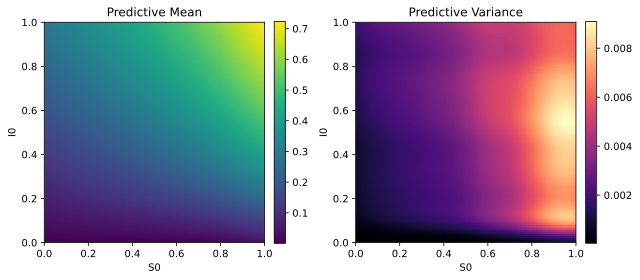

In [3]:
%config InlineBackend.figure_formats = ['svg']
from matplotlib import cm
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=1,ncols=2, figsize = (9,6))

# data
m = preds['mean'].reshape(100,100)
v = (preds['sd2'] + preds['nugs']).reshape(100,100)

ax0 = ax[0].imshow(m,origin='lower',extent=[0,1,0,1],cmap='viridis')
ax1 = ax[1].imshow(v,origin='lower',extent=[0,1,0,1],cmap='magma')
ax[0].set_title('Predictive Mean')
ax[1].set_title('Predictive Variance')
for a in ax:
    a.set_xlabel('S0')
    a.set_ylabel('I0')

kws = dict(fraction=0.046,pad=0.04)
f.colorbar(ax0, ax = ax[0],**kws)
f.colorbar(ax1, ax = ax[1],**kws)
f.tight_layout()

As discussed in the other resources linked at the beginning of this example, the interpretation of this example is that when there are a large amount of initital Susceptibles ($S_0 > ~ 0.8$) and a moderate amount of initial Infecteds ($I_0 > ~ 0.2$) see high variance in that some stochastic realizations result in large amounts of cumulative infections, but others do not. This is due to the high nonlinearity of an SIR model.